# An-Cockrell model reimplementation



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import h5py
from enum import IntEnum
from tqdm.notebook import tqdm

import an_cockrell
from an_cockrell import EpiType

In [2]:
%matplotlib inline

In [3]:
model = an_cockrell.AnCockrellModel(
    GRID_WIDTH=51,
    GRID_HEIGHT=51,
    is_bat=False,
    init_dcs=50,
    init_nks=25,
    init_macros=50,
    macro_phago_recovery=0.5,
    macro_phago_limit=1_000,
    inflammasome_activation_threshold=10,  # default 50 for bats
    inflammasome_priming_threshold=1.0,  # default 5.0 for bats
    viral_carrying_capacity=500,
    susceptibility_to_infection=77,
    human_endo_activation=5,
    bat_endo_activation=10,
    bat_metabolic_byproduct=2.0,
    human_metabolic_byproduct=0.2,
    resistance_to_infection=75,
    viral_incubation_threshold=60,
    MAX_DCS=50,  # DCs are constant, so == init_dcs
    MAX_NKS=25,  # NKs are constant, so == init_nks
    MAX_MACROPHAGES=100,  # number of macrophages is constant, but are born/die. So we don't need a big buffer
    # MAX_PMNS=1000,  # keep default
)

* Blue Squares = Healthy Epithelial Cells
* Yellow Squares = Infected Epithelial Cells
* Grey Squares = Epithelial Cells killed by necrosis
* Grey Pentagons = Epithelial Cells killed by apoptosis
* Green Circles = Macrophages
* Large Green Circles = Macrophages at phagocytosis limit
* Orange Circles = NK Cells
* Light Blue Triangles = Dendritic Cells
* Pink Square Outlines = Activated Endothelial Cells
* Small White Circles = PMNs

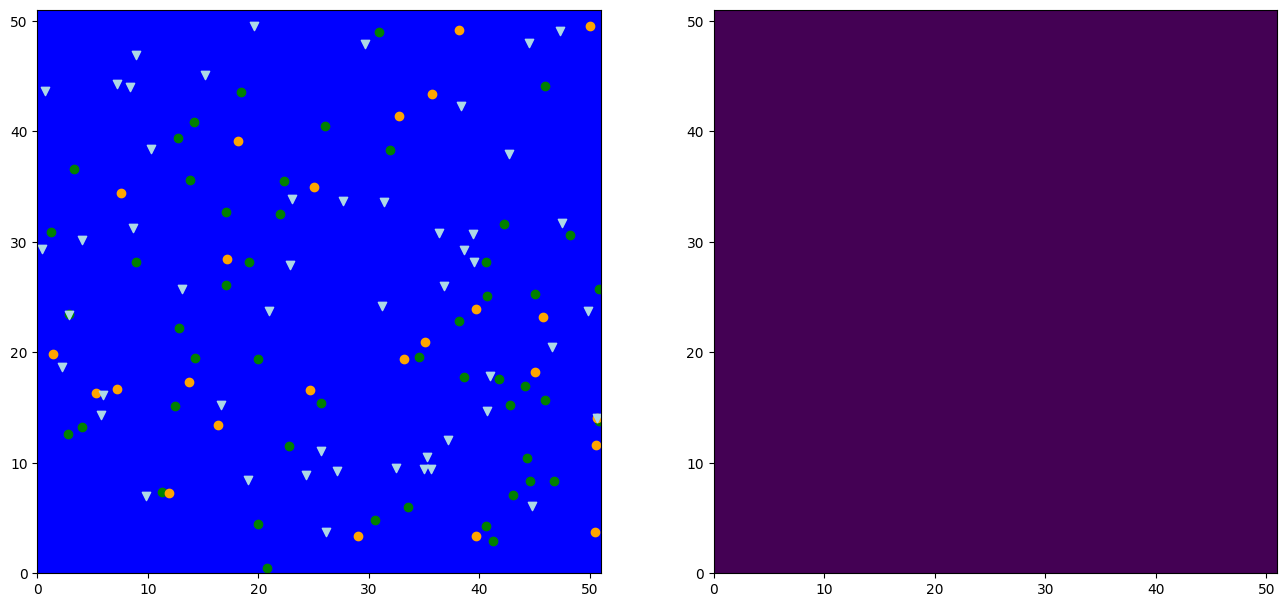

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

model.plot_agents(axs[0])
model.plot_field(axs[1], field_name="extracellular_virus")

axs[0].set_aspect(1)
axs[1].set_aspect(1)

In [5]:
model.infect(
    init_inoculum=100
)  # Initial-inoculum from 25-150 increments of 25, run for 14 days (2016 steps)

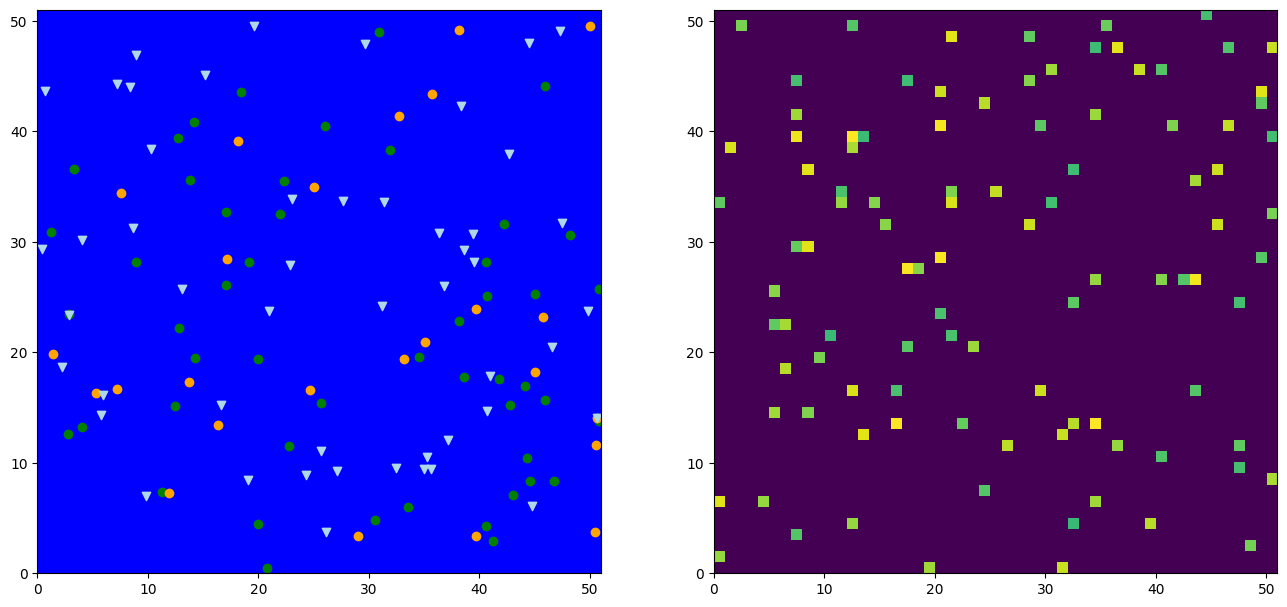

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

model.plot_agents(axs[0])
model.plot_field(axs[1], field_name="extracellular_virus")


axs[0].set_aspect(1)
axs[1].set_aspect(1)

In [7]:
num_steps = 2016  # <- full run value


class Task(IntEnum):
    html_anim = 0
    save_mpeg = 1
    make_hdf5 = 2


task = Task.make_hdf5

In [8]:
fields = [
    "extracellular_virus",
    "P_DAMPS",
    "ROS",
    "PAF",
    "TNF",
    "IL1",
    "IL18",
    "IL2",
    "IL4",
    "IL6",
    "IL8",
    "IL10",
    "IL12",
    "IL17",
    "IFNg",
    "T1IFN",
]

total_T1IFN = []
total_TNF = []
total_IFNg = []
total_IL6 = []
total_IL1 = []
total_IL8 = []
total_IL10 = []
total_IL12 = []
total_IL18 = []
total_extracellular_virus = []
total_intracellular_virus = []
apoptosis_eaten_counter = []
infected_epis = []
dead_epis = []
apoptosed_epis = []


pbar = tqdm(total=num_steps, display=False)

In [9]:
if task in {Task.html_anim, Task.save_mpeg}:
    fig = plt.figure(layout="constrained", figsize=(16, 8))
    fig.set_tight_layout(True)

    subfigs = fig.subfigures(1, 2, wspace=0.07)

    ax = subfigs[0].add_subplot()
    axs = subfigs[1].subplots(4, 4)

    def animate(i):
        model.time_step()
        pbar.update()

        total_T1IFN.append(model.total_T1IFN)
        total_TNF.append(model.total_TNF)
        total_IFNg.append(model.total_IFNg)
        total_IL6.append(model.total_IL6)
        total_IL1.append(model.total_IL1)
        total_IL8.append(model.total_IL8)
        total_IL10.append(model.total_IL10)
        total_IL12.append(model.total_IL12)
        total_IL18.append(model.total_IL18)
        total_extracellular_virus.append(model.total_extracellular_virus)
        total_intracellular_virus.append(model.total_intracellular_virus)
        apoptosis_eaten_counter.append(model.apoptosis_eaten_counter)
        infected_epis.append(np.sum(model.epithelium == EpiType.Infected))
        dead_epis.append(np.sum(model.epithelium == EpiType.Dead))
        apoptosed_epis.append(np.sum(model.epithelium == EpiType.Apoptosed))

        model.plot_agents(ax)
        ax.set_title(f"Agents; t={model.time}")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect(1)

        for k, field in enumerate(fields):
            model.plot_field(axs[k // 4, k % 4], field_name=field)
            axs[k // 4, k % 4].set_title(field)
            axs[k // 4, k % 4].get_xaxis().set_visible(False)
            axs[k // 4, k % 4].get_yaxis().set_visible(False)
            axs[k // 4, k % 4].set_aspect(1)

    pbar.update()
    anim = FuncAnimation(
        fig,
        animate,
        frames=num_steps,
        repeat=False,
        interval=100,  # half the default
    )

In [10]:
display(pbar.container)

if task == Task.html_anim:
    HTML(anim.to_html5_video())
elif task == Task.save_mpeg:
    anim.save("model-run.mpg")
elif task == Task.make_hdf5:
    model.save("test.hdf5")  # t=0
    for _ in range(num_steps):
        model.time_step()
        pbar.update()

        total_T1IFN.append(model.total_T1IFN)
        total_TNF.append(model.total_TNF)
        total_IFNg.append(model.total_IFNg)
        total_IL6.append(model.total_IL6)
        total_IL1.append(model.total_IL1)
        total_IL8.append(model.total_IL8)
        total_IL10.append(model.total_IL10)
        total_IL12.append(model.total_IL12)
        total_IL18.append(model.total_IL18)
        total_extracellular_virus.append(model.total_extracellular_virus)
        total_intracellular_virus.append(model.total_intracellular_virus)
        apoptosis_eaten_counter.append(model.apoptosis_eaten_counter)
        infected_epis.append(np.sum(model.epithelium == EpiType.Infected))
        dead_epis.append(np.sum(model.epithelium == EpiType.Dead))
        apoptosed_epis.append(np.sum(model.epithelium == EpiType.Apoptosed))

        model.save("test.hdf5")

  0%|          | 0/2016 [00:00<?, ?it/s]

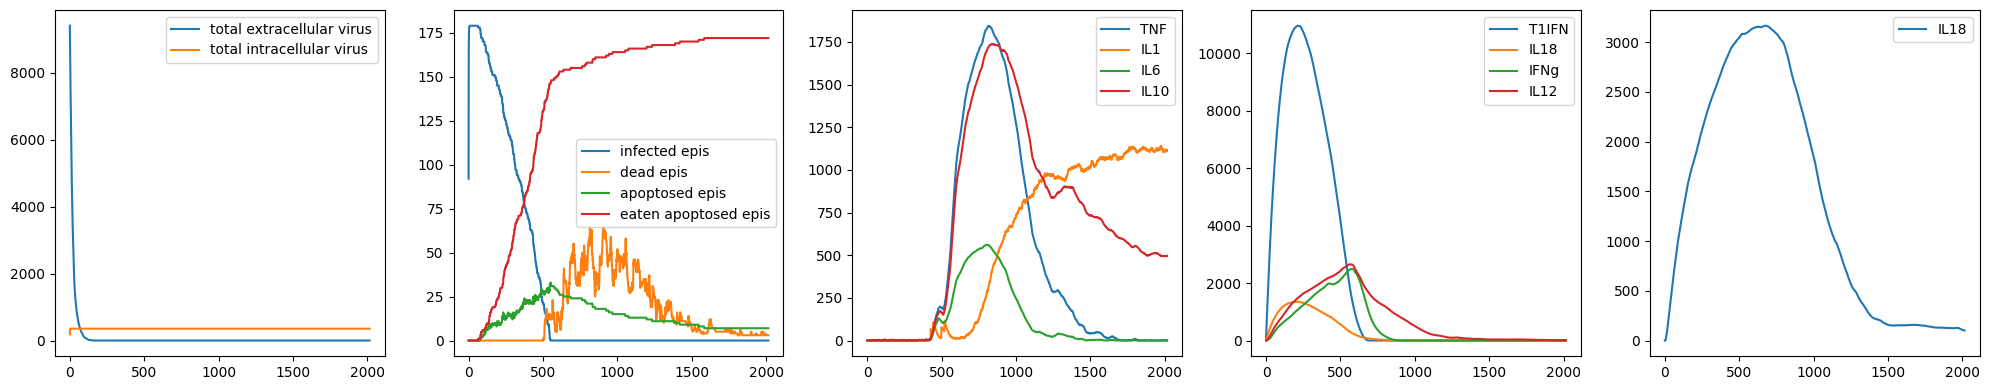

In [11]:
fig = plt.figure(layout="constrained", figsize=(20, 4))
fig.set_tight_layout(True)

axs = fig.subplots(1, 5)

axs[0].plot(total_extracellular_virus, label="total extracellular virus")
axs[0].plot(total_intracellular_virus, label="total intracellular virus")
axs[0].legend()

# axs[1] epis
axs[1].plot(infected_epis, label="infected epis")
axs[1].plot(dead_epis, label="dead epis")
axs[1].plot(apoptosed_epis, label="apoptosed epis")
axs[1].plot(apoptosis_eaten_counter, label="eaten apoptosed epis")
axs[1].legend()

axs[2].plot(total_TNF, label="TNF")
axs[2].plot(total_IL1, label="IL1")
axs[2].plot(total_IL6, label="IL6")
axs[2].plot(total_IL10, label="IL10")
axs[2].legend()


axs[3].plot(total_T1IFN, label="T1IFN")
axs[3].plot(total_IL18, label="IL18")
axs[3].plot(total_IFNg, label="IFNg")
axs[3].plot(total_IL12, label="IL12")
axs[3].legend()

axs[4].plot(total_IL8, label="IL18")  # not plotted in netlogo version, not sure why
axs[4].legend()